In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [314]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

from project_ssms.ar_truncated_normal_observation import ARTruncatedNormalObservation
from project_ssms.coupled_transformations.grid_transformation import GridTransformation
from project_ssms.unit_transformations import unit_direction_transformation
from project_ssms.feature_funcs import f_corner_vec_func, feature_direction_vec
from project_ssms.momentum_utils import filter_traj_by_speed, get_momentum_in_batch
from project_ssms.utils import downsample, k_step_prediction_for_artn_model
from project_ssms.plot_utils import plot_z, plot_2_mice, plot_4_traces
from project_ssms.grid_utils import *

import torch
import numpy as np

import joblib
import pickle

import matplotlib.pyplot as plt

# load data

In [131]:
data_dir = "/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc/data/trajs_all"

trajs = joblib.load(data_dir)

traj = trajs[36000*0:36000*5]
traj = downsample(traj, 2)
data = torch.tensor(traj, dtype=torch.float64)

# load model

In [16]:
model_4by4 = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition/n2K6_4by4_D190909_003253/checkpoint_2/model")
model_6by6 = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition/n2K6_6by6_D190909_003329/checkpoint_2/model")
model_8by8 = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition/n2K6_8by8_D190909_003504/checkpoint_2/model")

In [19]:
model_4by4_restart = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition/n2K6_4by4_restart_D190909_003728/checkpoint_2/model")
model_6by6_restart = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition/n2K6_6by6_restart_D190909_003759/checkpoint_2/model")
model_8by8_restart = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition/n2K6_8by8_restart_D190909_003832/checkpoint_2/model")

In [33]:
x_grids_4by4 = model_4by4.observation.transformation.x_grids
y_grids_4by4 = model_4by4.observation.transformation.y_grids

x_grids_6by6 = model_6by6.observation.transformation.x_grids
y_grids_6by6 = model_6by6.observation.transformation.y_grids

x_grids_8by8 = model_8by8.observation.transformation.x_grids
y_grids_8by8 = model_8by8.observation.transformation.y_grids


In [20]:
model_4by4.transition.stationary_transition_matrix

tensor([[0.9878, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.9878, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.9878, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.9878, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.9878, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.9878]], dtype=torch.float64)

In [21]:
model_4by4_restart.transition.stationary_transition_matrix

tensor([[0.9878, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.9878, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.9878, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.9878, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.9878, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.9878]], dtype=torch.float64)

In [22]:
model_6by6.transition.stationary_transition_matrix

tensor([[8.4905e-01, 4.3112e-02, 2.6431e-02, 2.9093e-02, 2.7067e-02, 2.5251e-02],
        [4.0817e-02, 8.4765e-01, 5.5421e-02, 4.6814e-02, 1.1881e-03, 8.1067e-03],
        [4.0342e-02, 8.4521e-02, 8.1719e-01, 8.6170e-03, 3.7590e-02, 1.1744e-02],
        [1.9559e-02, 3.6235e-02, 4.8938e-03, 8.9008e-01, 4.1345e-07, 4.9227e-02],
        [7.9667e-02, 3.6968e-03, 7.2871e-02, 9.6942e-06, 7.6378e-01, 7.9977e-02],
        [3.8603e-02, 1.0550e-02, 9.2011e-03, 9.5877e-02, 3.4459e-02, 8.1131e-01]],
       dtype=torch.float64)

In [23]:
model_6by6_restart.transition.stationary_transition_matrix

tensor([[0.9878, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.9878, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.9878, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.9878, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.9878, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.9878]], dtype=torch.float64)

In [24]:
model_8by8.transition.stationary_transition_matrix

tensor([[7.9456e-01, 5.2581e-03, 1.0189e-01, 3.4263e-02, 5.0616e-02, 1.3414e-02],
        [3.8625e-03, 8.5945e-01, 6.5466e-02, 6.4388e-04, 3.0531e-02, 4.0044e-02],
        [4.0122e-02, 4.3736e-02, 8.8212e-01, 1.7211e-03, 1.3682e-02, 1.8617e-02],
        [5.1678e-02, 1.5877e-03, 5.8166e-03, 7.7466e-01, 7.6552e-02, 8.9702e-02],
        [2.9897e-02, 3.1088e-02, 2.6000e-02, 3.2297e-02, 8.5225e-01, 2.8468e-02],
        [1.0623e-02, 4.8123e-02, 2.8400e-02, 4.4215e-02, 2.5393e-02, 8.4325e-01]],
       dtype=torch.float64)

In [25]:
model_8by8_restart.transition.stationary_transition_matrix

tensor([[0.9878, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.9878, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.9878, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.9878, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.9878, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.9878]], dtype=torch.float64)

need to re-run experiments for

model 6by6, model 8by8
(or not? since we have restart...)

In [104]:
numbers = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition/n2K6_4by4_D190909_003253/checkpoint_2/numbers")

In [105]:
numbers.keys()

dict_keys(['z', 'x_predict', 'x_predict_5', 'sample_z', 'sample_x', 'sample_z_center', 'sample_x_center', 'losses'])

In [108]:
sample_x = numbers['sample_x']
sample_z = numbers['sample_z']
sample_x_center = numbers['sample_x_center']
sample_z_center = numbers['sample_z_center']

In [205]:
def z_to_color(z):
    for k in range(model_4by4.K):
        if z == k:
            return 'C{}'.format(k)

In [207]:
colors_sample_z = list(map(z_to_color, sample_z))

In [125]:
colors_sample_z_center = list(map(z_to_color, sample_z_center))

In [120]:
len(colors_sample_z)

36000

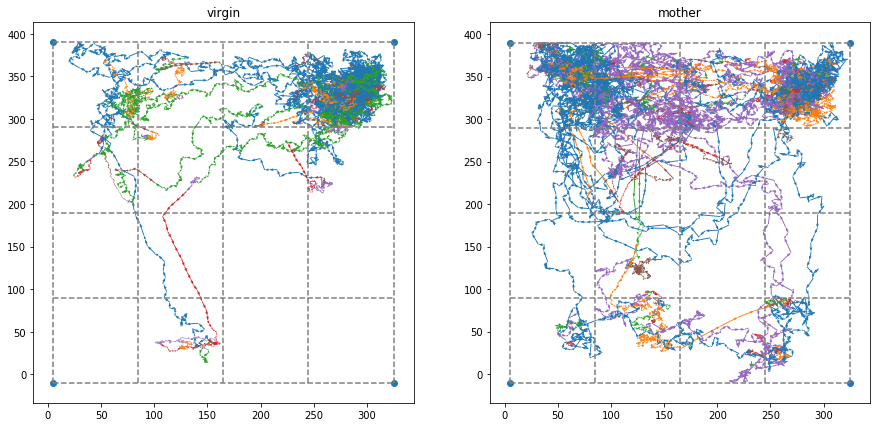

In [142]:
plot_realdata_quiver(sample_x[:18000], x_grids_4by4, y_grids_4by4, scale=1, color=colors_sample_z[:18000])

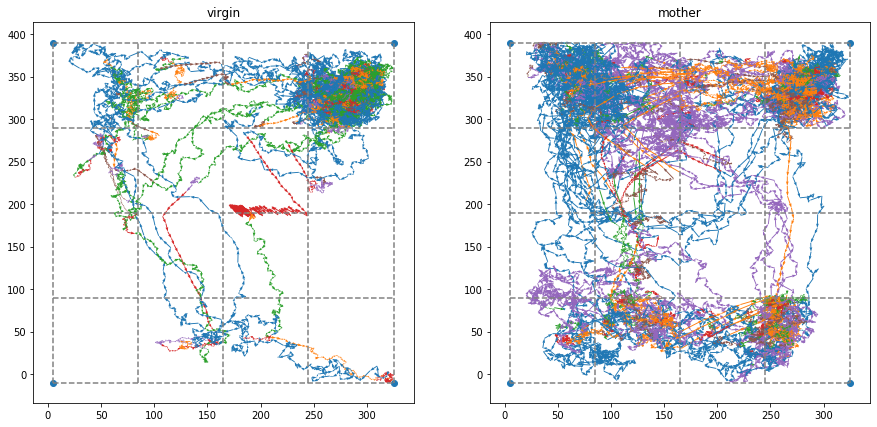

In [143]:
plot_realdata_quiver(sample_x, x_grids_4by4, y_grids_4by4, scale=1, color=colors_sample_z)

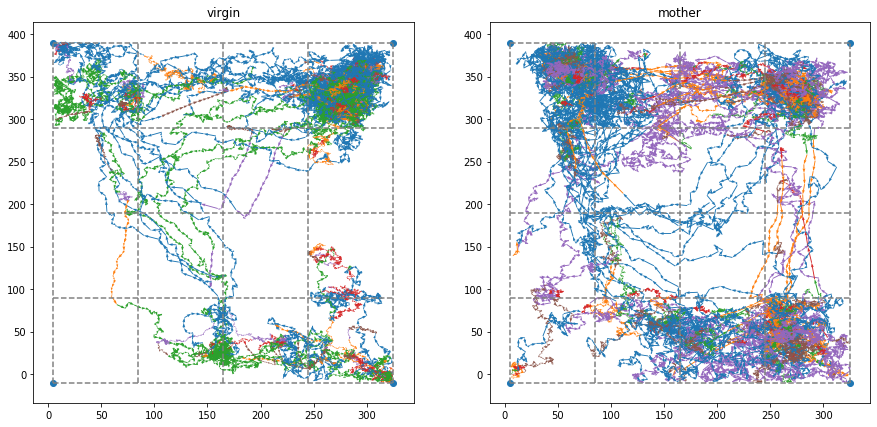

In [126]:
plot_realdata_quiver(sample_x_center, x_grids_4by4, y_grids_4by4, scale=1, color=colors_sample_z_center)

In [128]:
realdata_z = numbers['z']

In [129]:
colors_realdata_z = list(map(z_to_color, realdata_z))

In [133]:
data.shape

torch.Size([90000, 4])

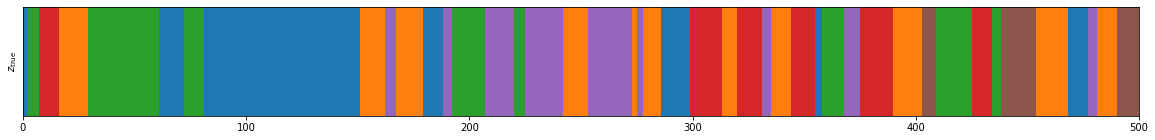

In [166]:
plot_z(realdata_z[1500:2000], model_4by4.K)

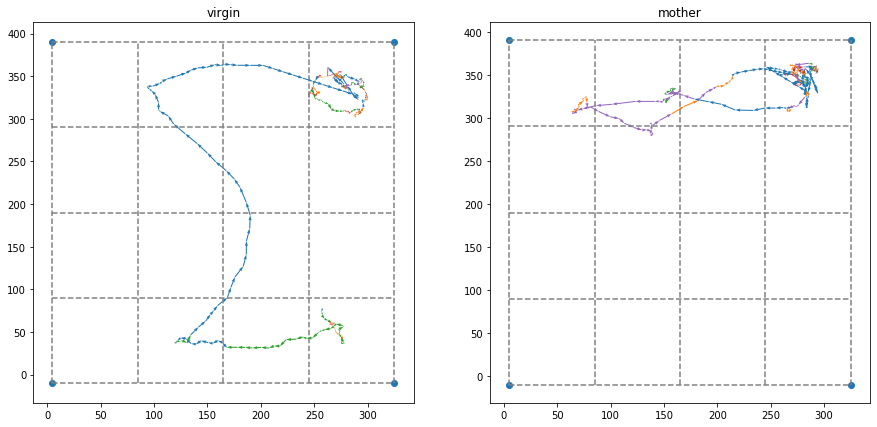

In [167]:
plot_realdata_quiver(data[1500:2000], x_grids_4by4, y_grids_4by4, scale=1, color=colors_realdata_z[1500:2000])

In [165]:
model_4by4.transition.stationary_transition_matrix

tensor([[0.9878, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.9878, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.9878, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.9878, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.9878, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.9878]], dtype=torch.float64)

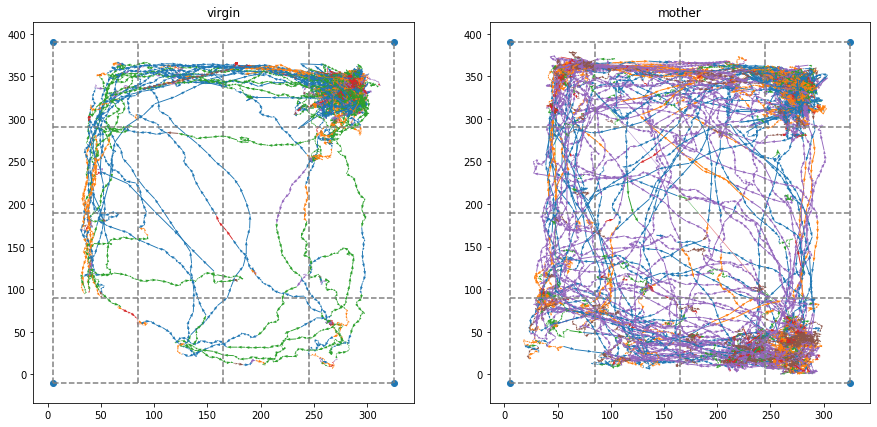

In [168]:
plot_realdata_quiver(data[0:30000], x_grids_4by4, y_grids_4by4, scale=1, color=colors_realdata_z[0:30000])

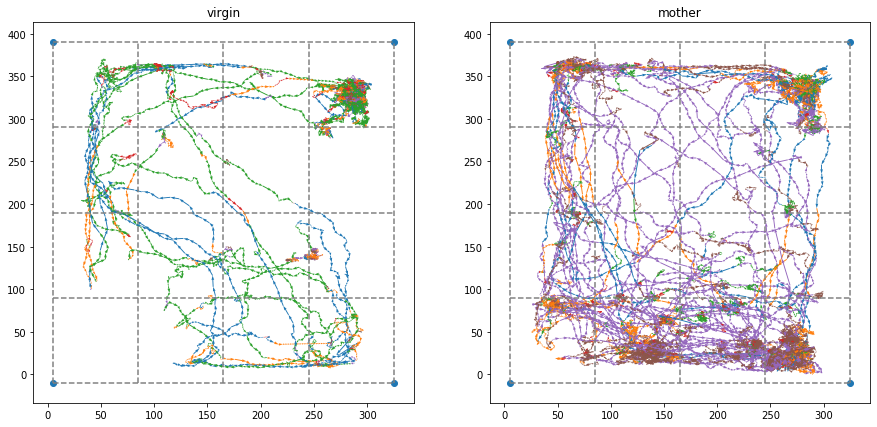

In [139]:
plot_realdata_quiver(data[30000:60000], x_grids_4by4, y_grids_4by4, scale=1, color=colors_realdata_z[30000:60000])

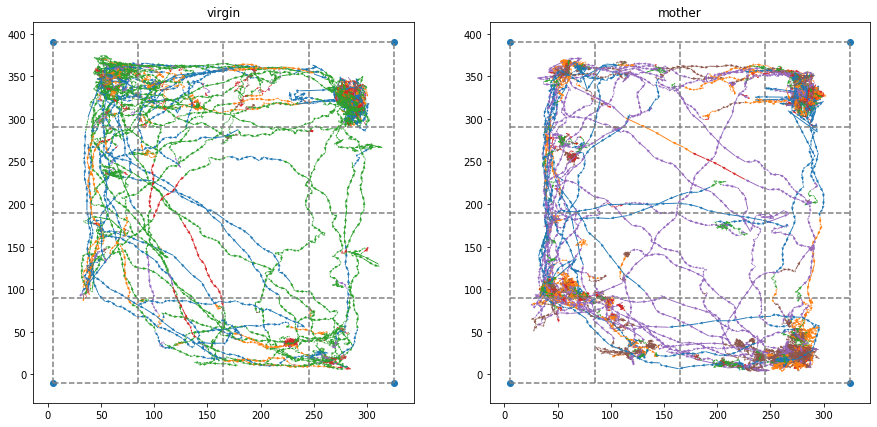

In [141]:
plot_realdata_quiver(data[60000:90000], x_grids_4by4, y_grids_4by4, scale=1, color=colors_realdata_z[60000:90000])

In [ ]:
# color real data
# draw conclusion

In [49]:
sample_T = 5000

zs = [np.ones(sample_T) * k for k in range(model_4by4.K)]

In [55]:
x_centers = (np.array(x_grids_4by4[1:]) + np.array(x_grids_4by4[0:-1])) / 2
y_centers = (np.array(y_grids_4by4[1:]) + np.array(y_grids_4by4[0:-1])) / 2

centers = np.array([(x_center, y_center, x_center, y_center) for x_center in x_centers for y_center in y_centers])

In [54]:
centers.shape

(16, 2)

In [63]:
centers

array([[ 45.,  40.,  45.,  40.],
       [ 45., 140.,  45., 140.],
       [ 45., 240.,  45., 240.],
       [ 45., 340.,  45., 340.],
       [125.,  40., 125.,  40.],
       [125., 140., 125., 140.],
       [125., 240., 125., 240.],
       [125., 340., 125., 340.],
       [205.,  40., 205.,  40.],
       [205., 140., 205., 140.],
       [205., 240., 205., 240.],
       [205., 340., 205., 340.],
       [285.,  40., 285.,  40.],
       [285., 140., 285., 140.],
       [285., 240., 285., 240.],
       [285., 340., 285., 340.]])

In [56]:
out = np.array([[0 for i in range(3)] for j in range(4)])
out.shape

(4, 3)

In [57]:
xs = [[model_4by4.sample_condition_on_zs(zs=zs_0, x0=x_0) for x_0 in centers]for zs_0 in zs ]

k = 0

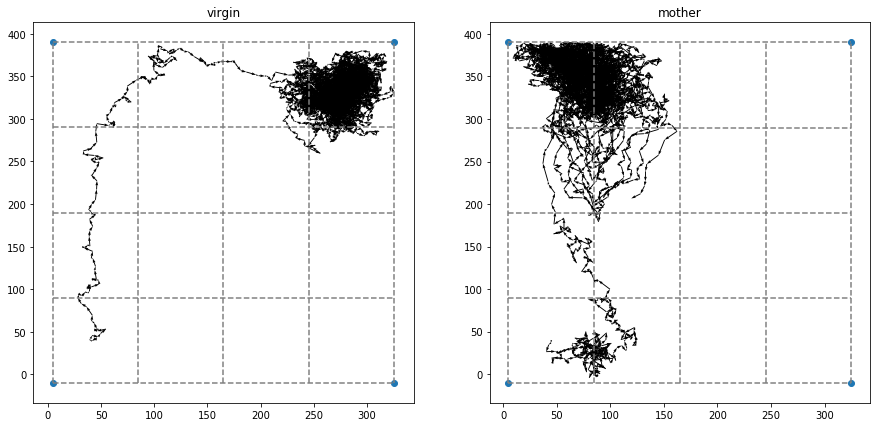

In [60]:
plot_realdata_quiver(xs[0][0], x_grids_4by4, y_grids_4by4, scale=1)

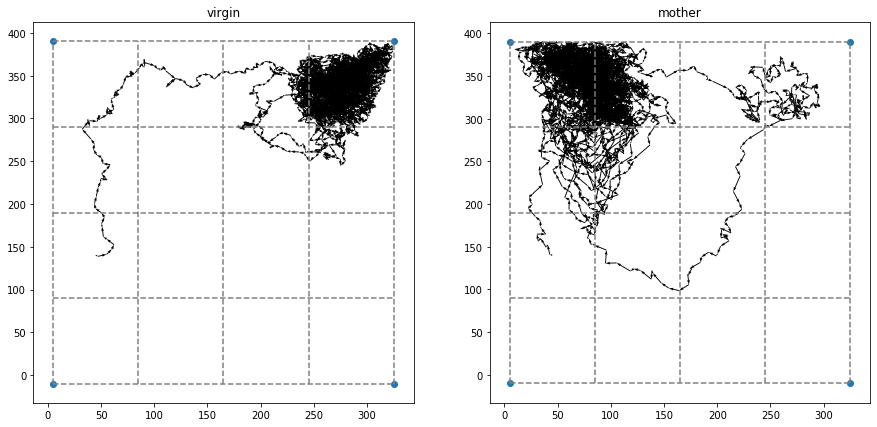

In [61]:
plot_realdata_quiver(xs[0][1], x_grids_4by4, y_grids_4by4, scale=1)

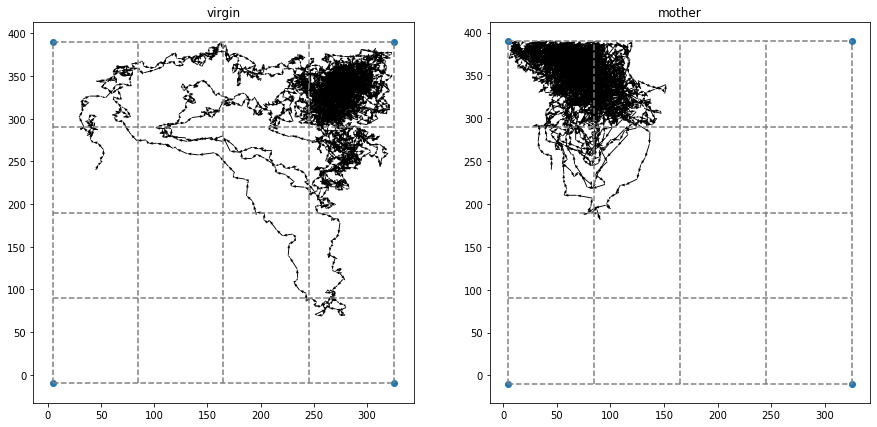

In [62]:
plot_realdata_quiver(xs[0][2], x_grids_4by4, y_grids_4by4, scale=1)

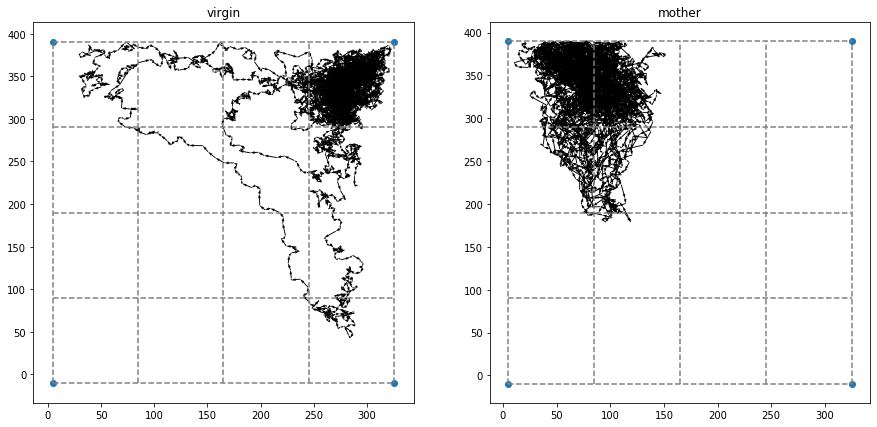

In [66]:
plot_realdata_quiver(xs[0][3], x_grids_4by4, y_grids_4by4, scale=1)

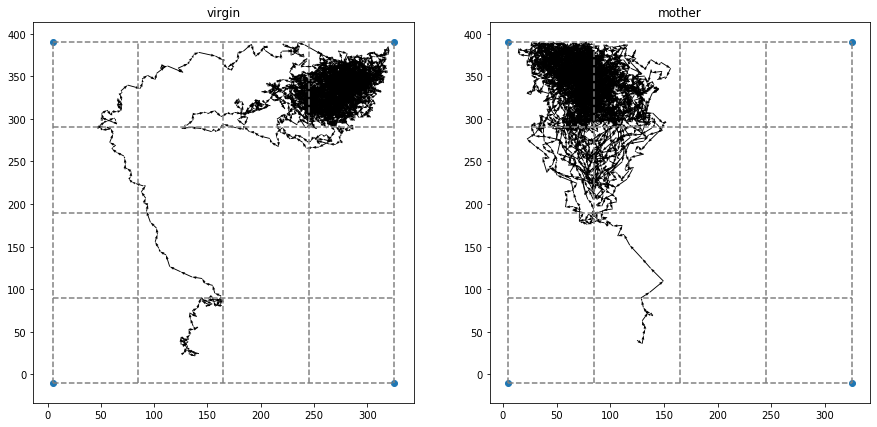

In [67]:
plot_realdata_quiver(xs[0][4], x_grids_4by4, y_grids_4by4, scale=1)

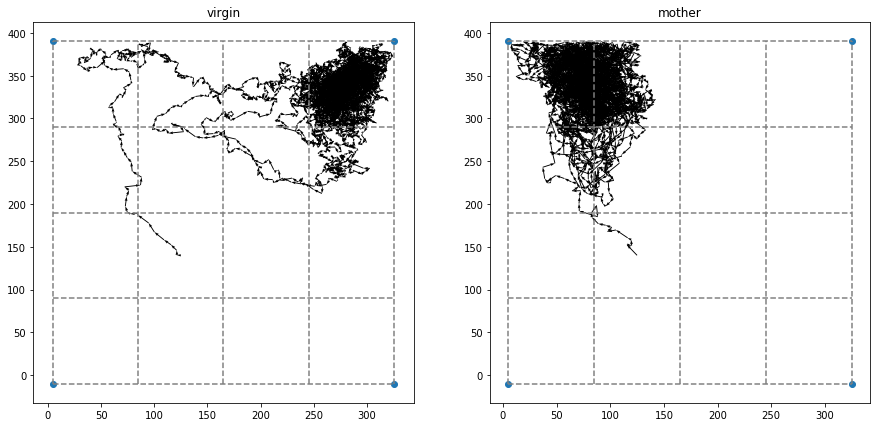

In [68]:
plot_realdata_quiver(xs[0][5], x_grids_4by4, y_grids_4by4, scale=1)

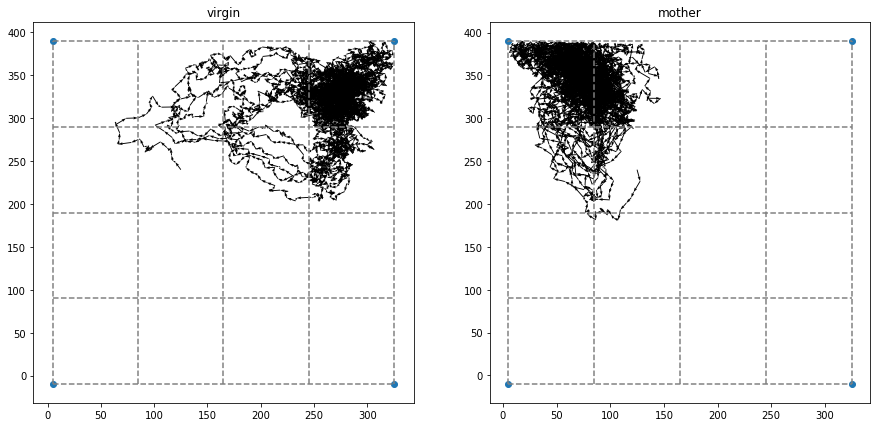

In [69]:
plot_realdata_quiver(xs[0][6], x_grids_4by4, y_grids_4by4, scale=1)

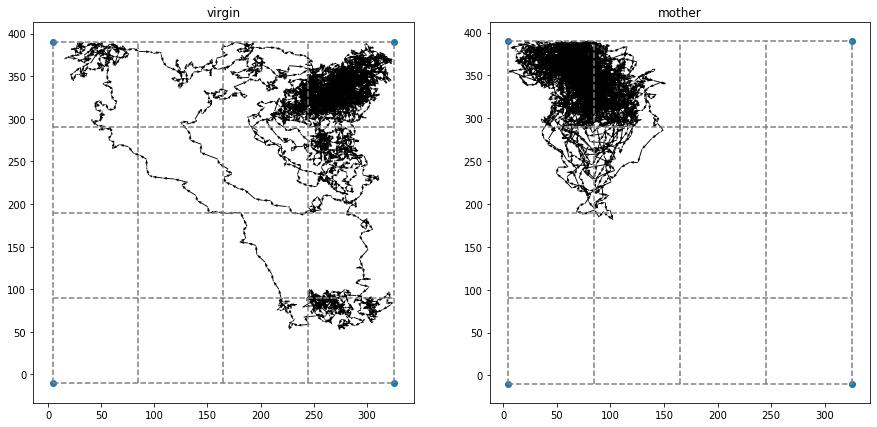

In [70]:
plot_realdata_quiver(xs[0][7], x_grids_4by4, y_grids_4by4, scale=1)

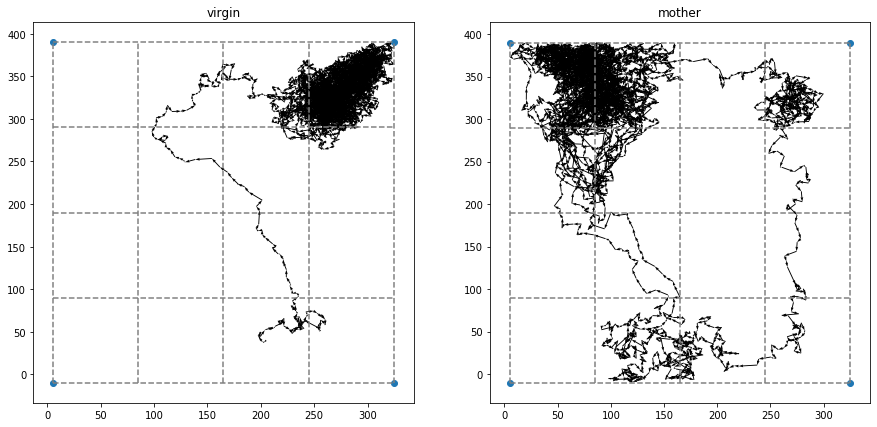

In [71]:
plot_realdata_quiver(xs[0][8], x_grids_4by4, y_grids_4by4, scale=1)

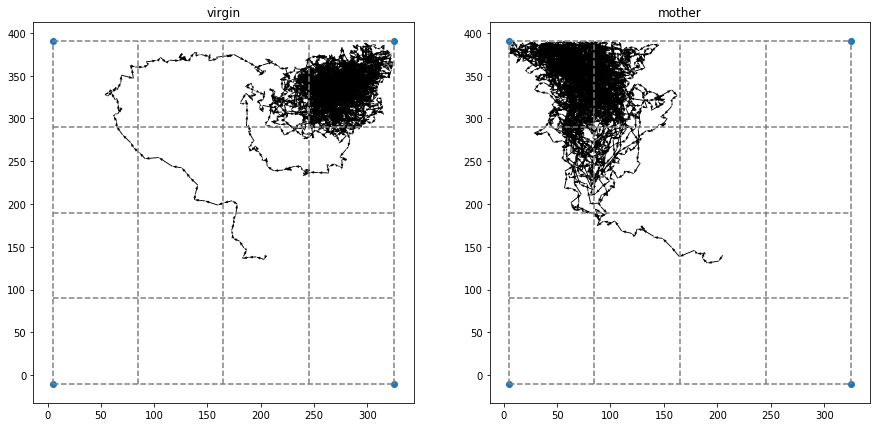

In [72]:
plot_realdata_quiver(xs[0][9], x_grids_4by4, y_grids_4by4, scale=1)

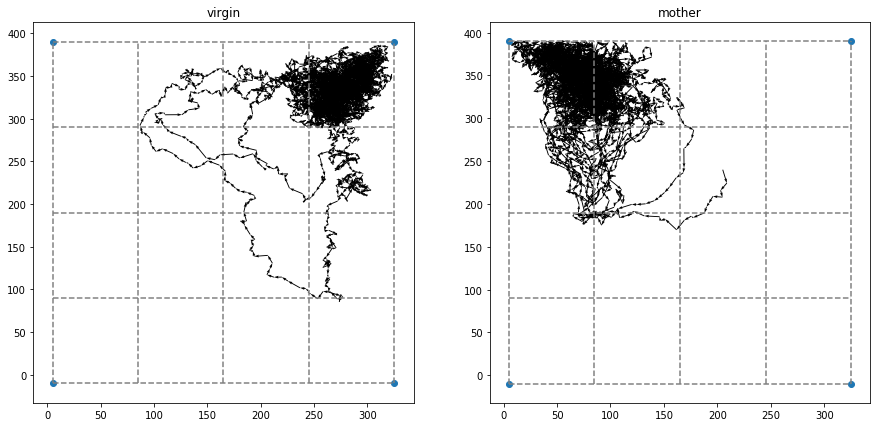

In [73]:
plot_realdata_quiver(xs[0][10], x_grids_4by4, y_grids_4by4, scale=1)

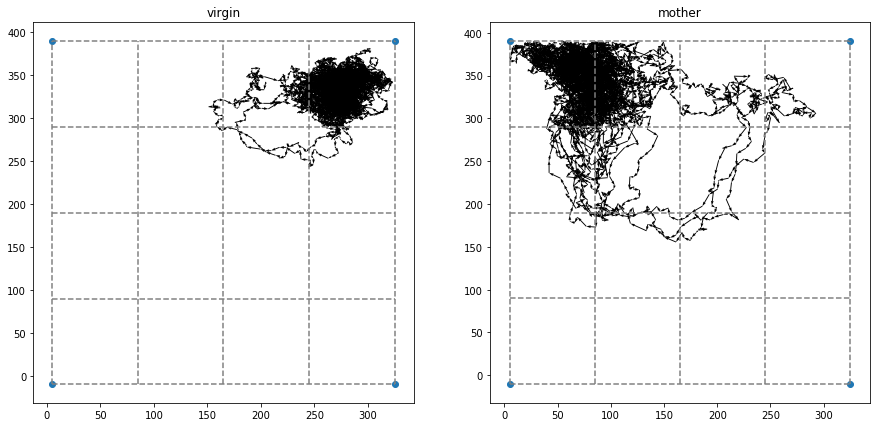

In [74]:
plot_realdata_quiver(xs[0][11], x_grids_4by4, y_grids_4by4, scale=1)

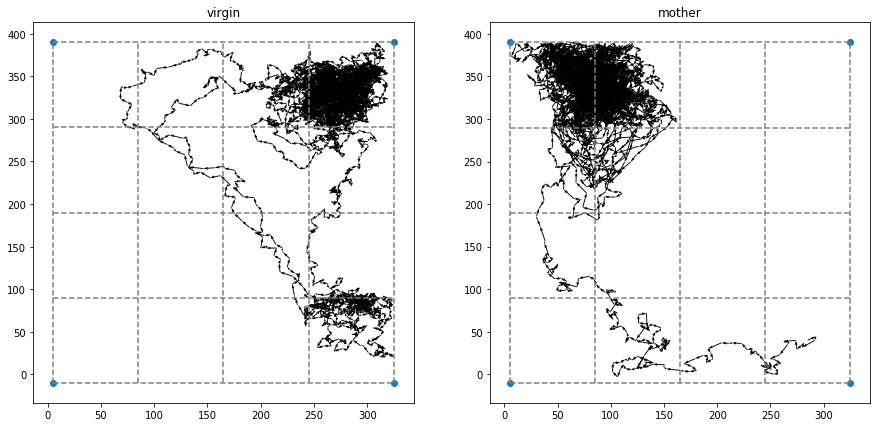

In [75]:
plot_realdata_quiver(xs[0][12], x_grids_4by4, y_grids_4by4, scale=1)

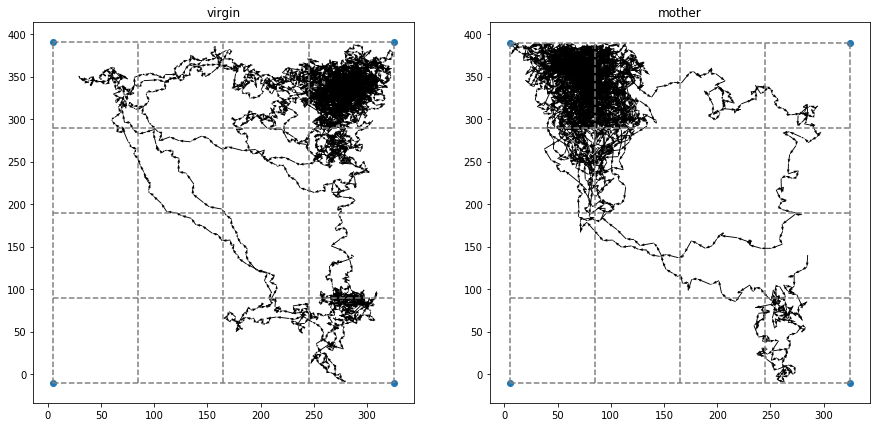

In [76]:
plot_realdata_quiver(xs[0][13], x_grids_4by4, y_grids_4by4, scale=1)

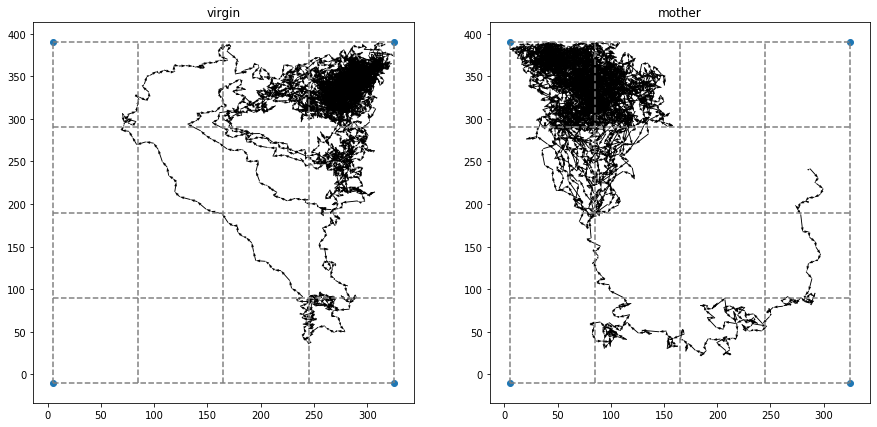

In [77]:
plot_realdata_quiver(xs[0][14], x_grids_4by4, y_grids_4by4, scale=1)

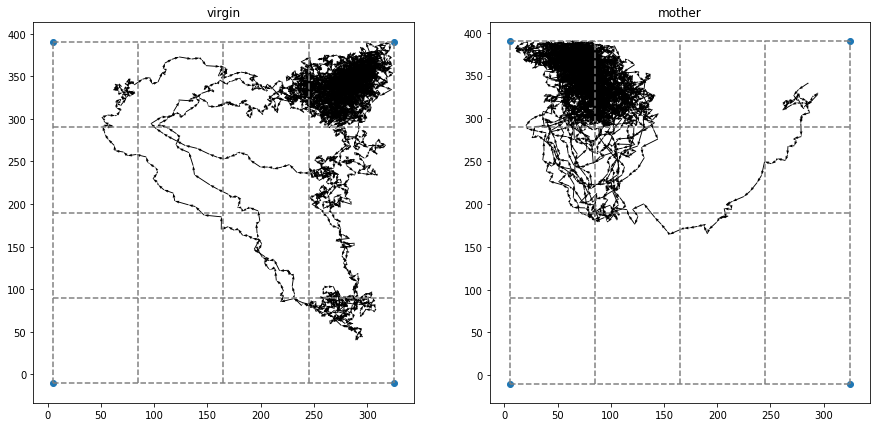

In [78]:
plot_realdata_quiver(xs[0][15], x_grids_4by4, y_grids_4by4, scale=1)

k = 1

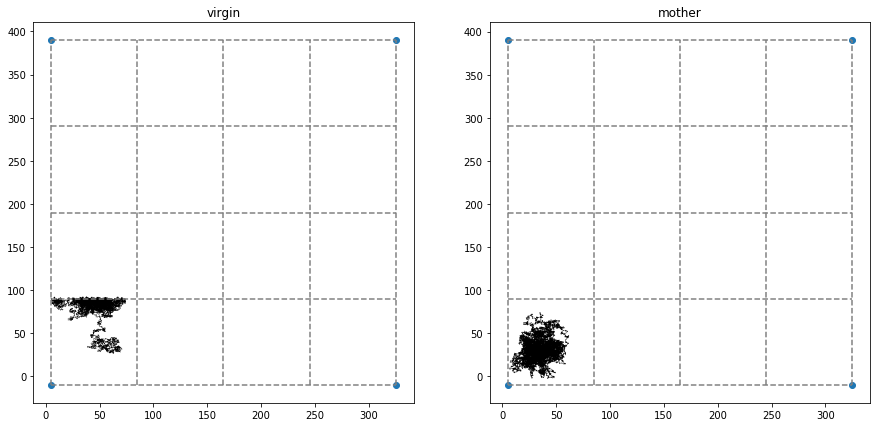

In [79]:
plot_realdata_quiver(xs[1][0], x_grids_4by4, y_grids_4by4, scale=1)

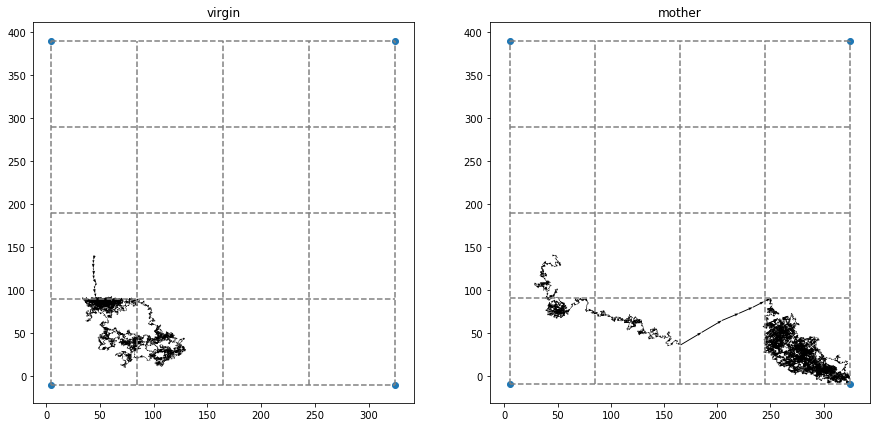

In [84]:
plot_realdata_quiver(xs[1][1], x_grids_4by4, y_grids_4by4, scale=1)

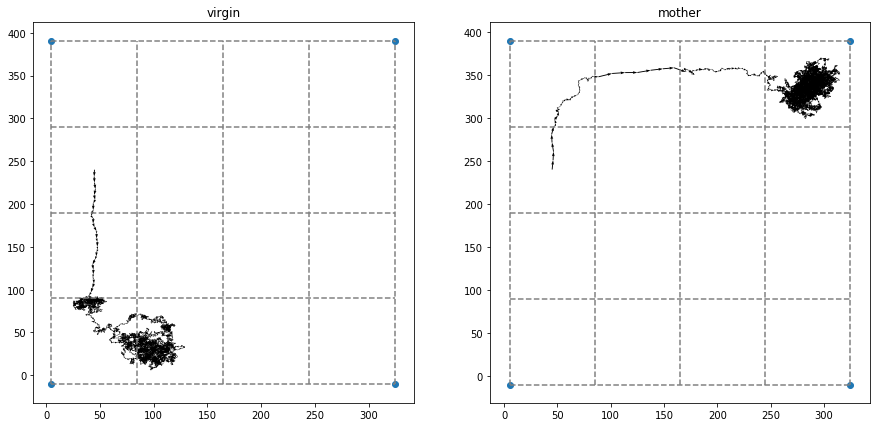

In [86]:
plot_realdata_quiver(xs[1][2], x_grids_4by4, y_grids_4by4, scale=1)

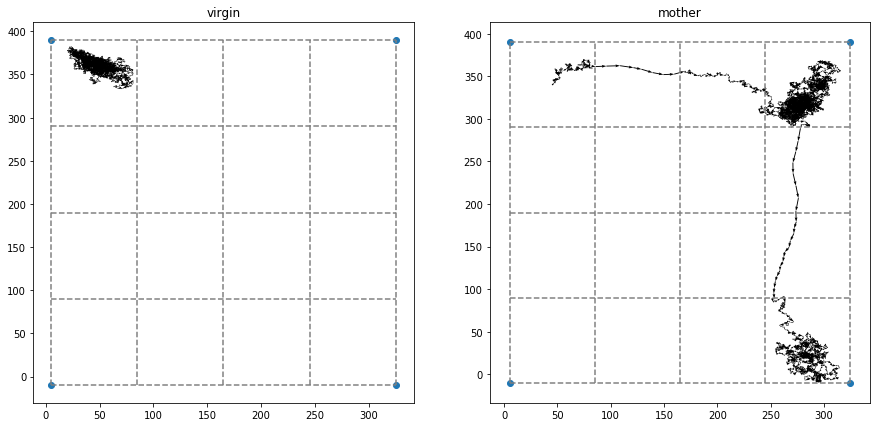

In [85]:
plot_realdata_quiver(xs[1][3], x_grids_4by4, y_grids_4by4, scale=1)

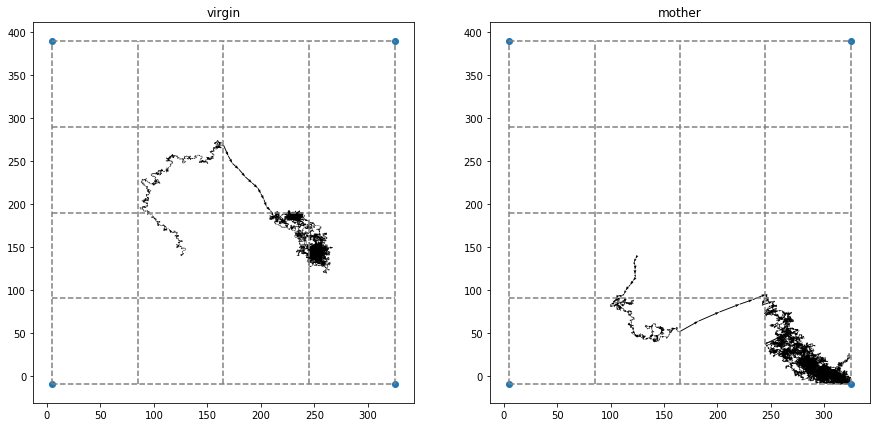

In [80]:
plot_realdata_quiver(xs[1][5], x_grids_4by4, y_grids_4by4, scale=1)

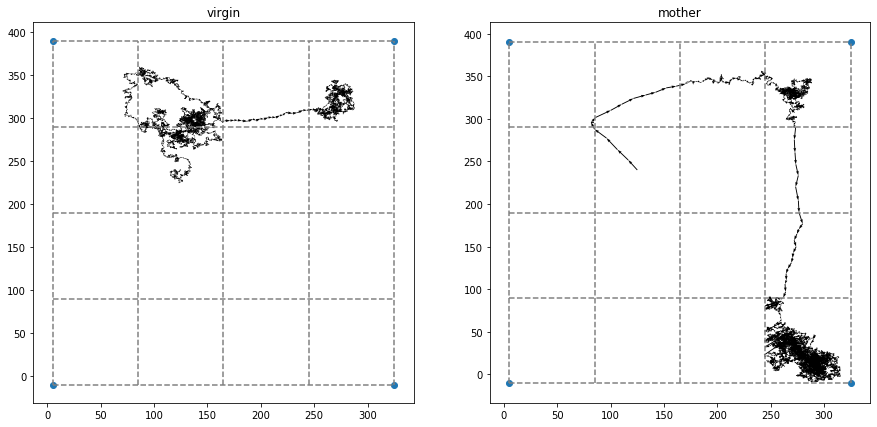

In [87]:
plot_realdata_quiver(xs[1][6], x_grids_4by4, y_grids_4by4, scale=1)

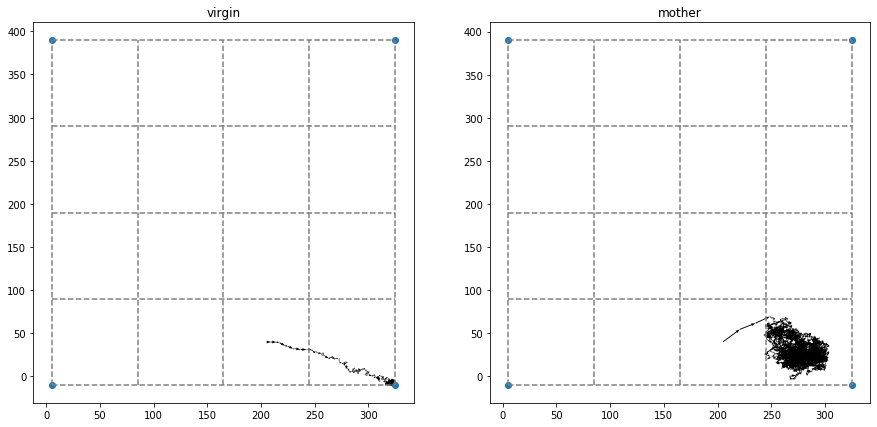

In [81]:
plot_realdata_quiver(xs[1][8], x_grids_4by4, y_grids_4by4, scale=1)

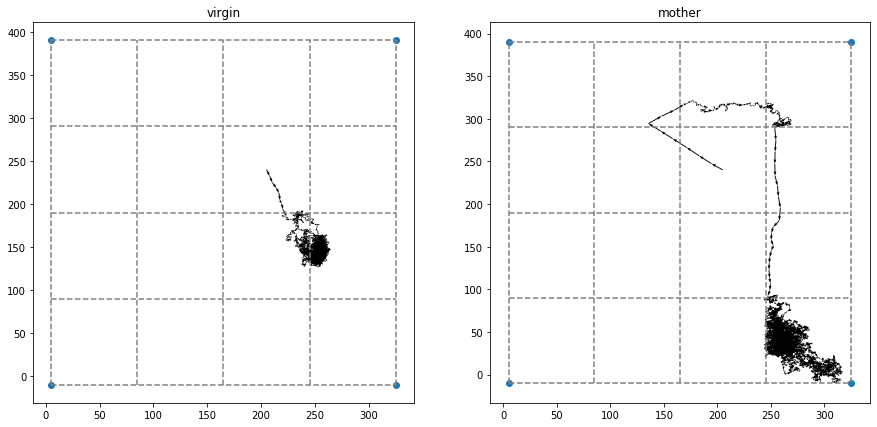

In [82]:
plot_realdata_quiver(xs[1][10], x_grids_4by4, y_grids_4by4, scale=1)

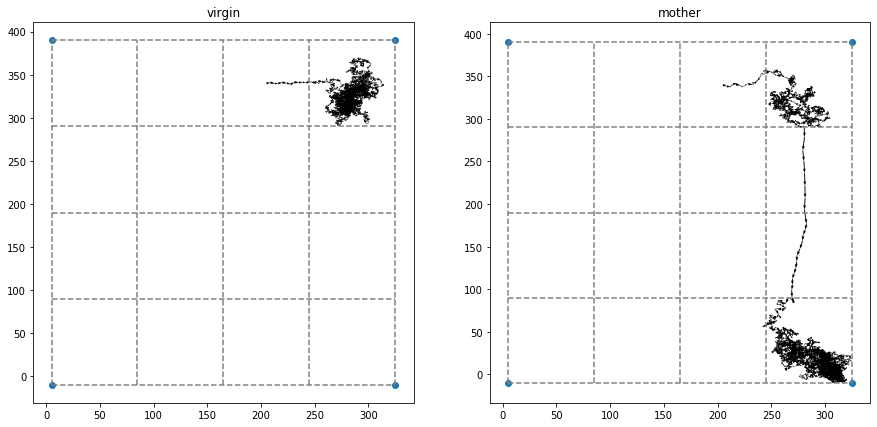

In [88]:
plot_realdata_quiver(xs[1][11], x_grids_4by4, y_grids_4by4, scale=1)

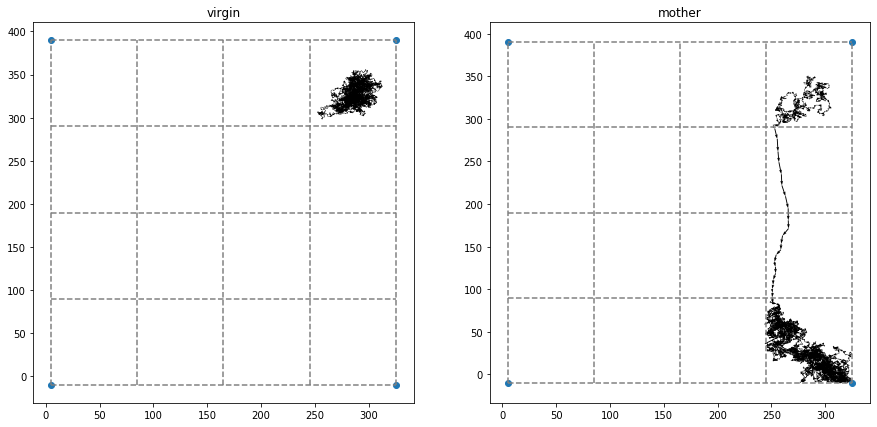

In [83]:
plot_realdata_quiver(xs[1][15], x_grids_4by4, y_grids_4by4, scale=1)

problem in sampling

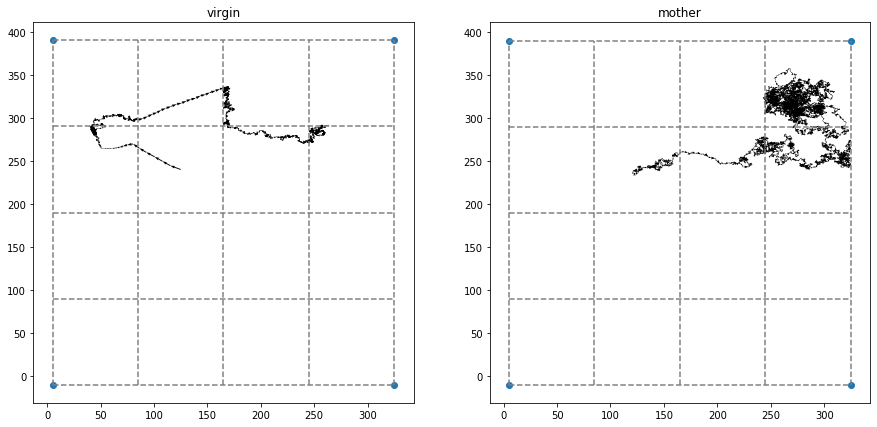

In [89]:
plot_realdata_quiver(xs[5][6], x_grids_4by4, y_grids_4by4, scale=1)

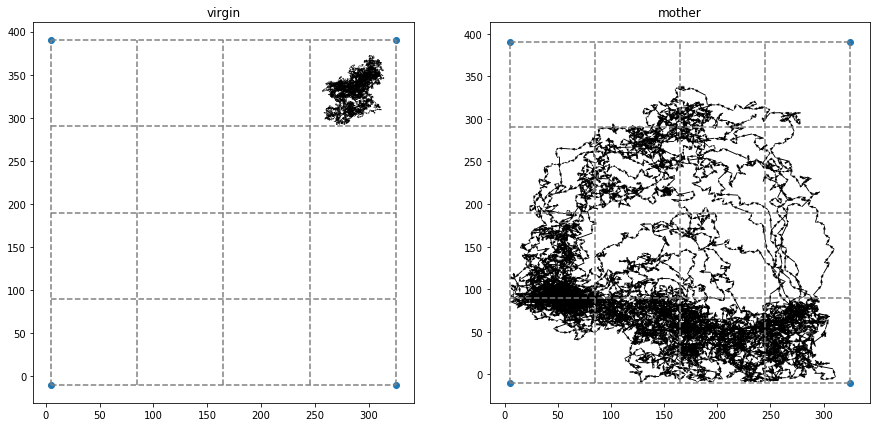

In [40]:
plot_realdata_quiver(xs_4, x_grids_4by4, y_grids_4by4, scale=1)

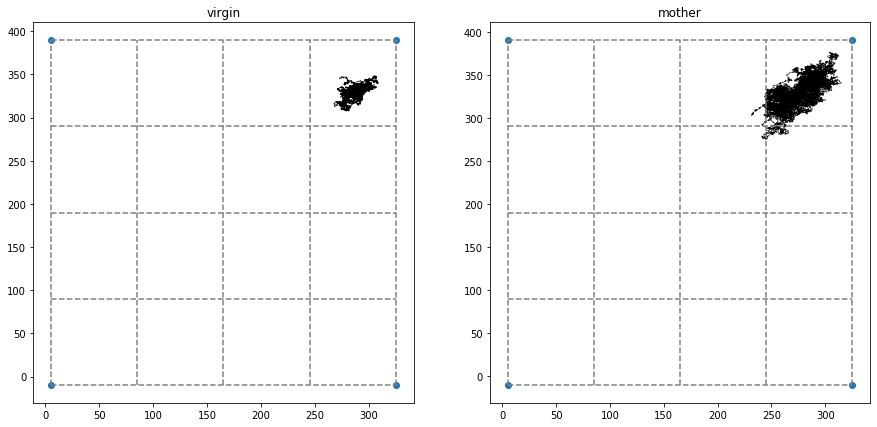

In [41]:
plot_realdata_quiver(xs_5, x_grids_4by4, y_grids_4by4, scale=1)

transition matrix that is closer to identity

In [169]:
model_4by4_s = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition_strict/n2K6_4by4_D190909_004209/checkpoint_2/model")
model_6by6_s = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition_strict/n2K6_6by6_D190909_004236/checkpoint_2/model")
model_8by8_s = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition_strict/n2K6_8by8_D190909_004305/checkpoint_2/model")

In [170]:
model_4by4_s.transition.stationary_transition_matrix

tensor([[9.9938e-01, 1.2333e-04, 1.2333e-04, 1.2333e-04, 1.2333e-04, 1.2333e-04],
        [1.2333e-04, 9.9938e-01, 1.2333e-04, 1.2333e-04, 1.2333e-04, 1.2333e-04],
        [1.2333e-04, 1.2333e-04, 9.9938e-01, 1.2333e-04, 1.2333e-04, 1.2333e-04],
        [1.2333e-04, 1.2333e-04, 1.2333e-04, 9.9938e-01, 1.2333e-04, 1.2333e-04],
        [1.2333e-04, 1.2333e-04, 1.2333e-04, 1.2333e-04, 9.9938e-01, 1.2333e-04],
        [1.2333e-04, 1.2333e-04, 1.2333e-04, 1.2333e-04, 1.2333e-04, 9.9938e-01]],
       dtype=torch.float64)

In [171]:
numbers_s = joblib.load("/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/0909_fix_transition_strict/n2K6_4by4_D190909_004209/checkpoint_2/numbers")

In [172]:
realdata_s_z = numbers_s['z']

In [174]:
colors_realdata_s_z = list(map(z_to_color, realdata_s_z))

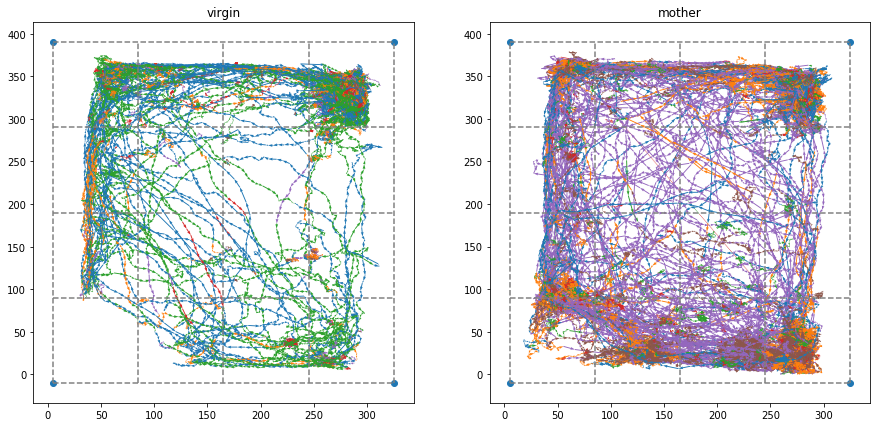

In [176]:
plot_realdata_quiver(data, x_grids_4by4, y_grids_4by4, scale=1, color=colors_realdata_s_z)

In [189]:
sample_x_s = numbers_s['sample_x']
sample_z_s = numbers_s['sample_z']
sample_x_center_s = numbers_s['sample_x_center']
sample_z_center_s = numbers_s['sample_z_center']

In [190]:
colors_sample_z_s = list(map(z_to_color, sample_z_s))
colors_sample_z_center_s = list(map(z_to_color, sample_z_center_s))

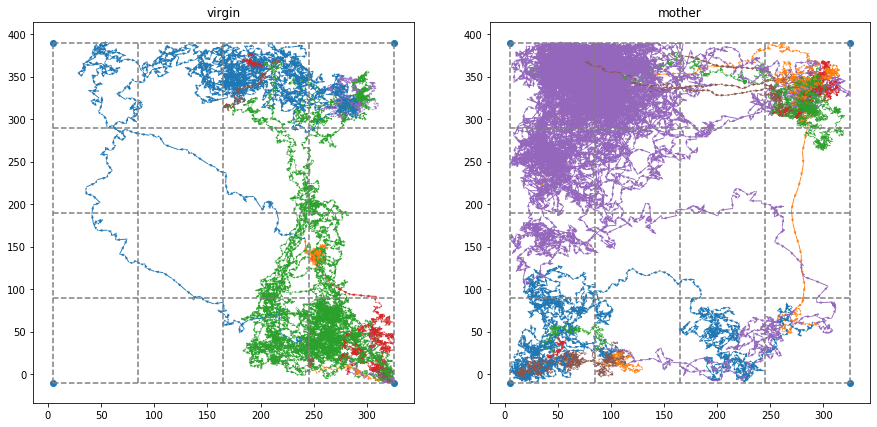

In [191]:
plot_realdata_quiver(sample_x_s, x_grids_4by4, y_grids_4by4, scale=1, color=colors_sample_z_s)

In [318]:
sample_x_center_s.shape

(36000, 4)

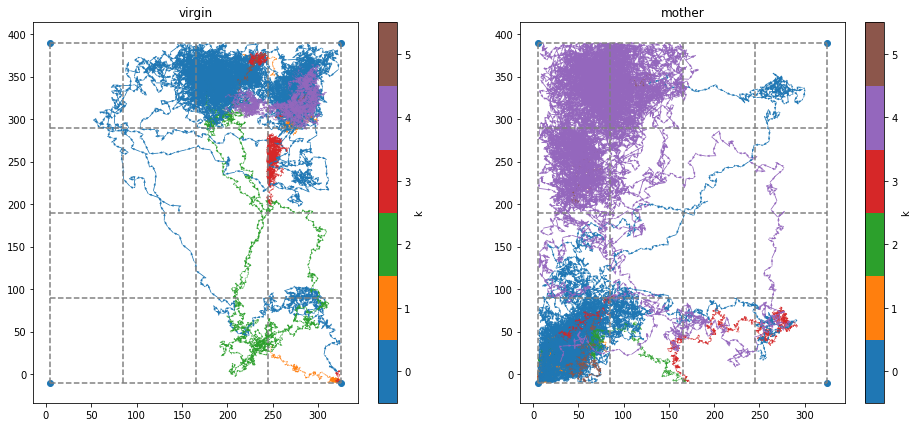

In [352]:
plot_realdata_quiver(sample_x_center_s, model_4by4.K, x_grids_4by4, y_grids_4by4, scale=1, color=colors_sample_z_center_s)

In [369]:
def plot_z(z, K, plot_range=None, ylim=None, title=None):
    cmap = get_cmap(K)
    if plot_range is None:
        plot_range=(0, z.shape[0])
    if ylim is None:
        ylim = (0, 1)
    plt.figure(figsize=(20, 2))
    if title is not None:
        plt.title(title)
    plt.imshow(z[None, plot_range[0]:plot_range[1]], aspect="auto", cmap=cmap,
               vmin=0, vmax=K-1, extent=(plot_range[0], plot_range[1], ylim[0], ylim[1]))
    plt.xlim(plot_range[0], plot_range[1])
    plt.ylabel("$z_{\\mathrm{true}}$")
    plt.yticks([])

    h = 5/K
    ticks = [(1 / 2 + k) * h for k in range(K)]
    cb = plt.colorbar(label='k', ticks=ticks)
    cb.set_ticklabels(range(K))

In [370]:
model_4by4_s.K

6

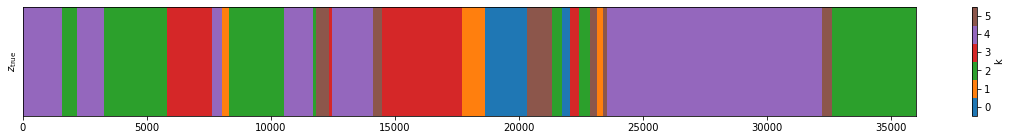

In [371]:
plot_z(sample_z_s, model_4by4_s.K)

[0.125, 0.375, 0.625, 0.875]

In [381]:
grids = torch.tensor([(x_grid, y_grid) for x_grid in x_grids_4by4 for y_grid in y_grids_4by4])

In [386]:
grids[[0,1]]

tensor([[  5., -10.],
        [  5.,  90.]])

In [389]:
points = torch.rand((10,2,3))

In [390]:
def f(point):
    return point+1

In [402]:
out = torch.stack(list(map(f, points)), dim=0)

In [404]:
out[0]

tensor([[1.7845, 1.1266, 1.0527],
        [1.5835, 1.9932, 1.1161]])

In [419]:
points = torch.rand(1,1,10)
points = torch.squeeze(points)
points.shape

torch.Size([10])

In [436]:
T = 2
K = 3
GP = 9
Df = 4
weights = torch.rand((K, GP, Df))

In [447]:
a = torch.tensor([[0,1,2,3], [2,3,4,5]])

In [448]:
a.shape

torch.Size([2, 4])

In [452]:
a[...,0:1].shape

torch.Size([2, 1])

In [453]:
b = torch.tensor([2,3,4])

In [462]:
a[:,-2]

tensor([2, 4])

## original model

[1, 2, 3, 4, 5, 6]